In [1]:
!pip install natsort

# Introduction

- Dermatologists suffer from the difficulty of locating cancerous and malignant skin lesions, which causes many problems during the process of removing the tumor, which leads to the return of the tumor again. In determining the location of the tumor and its spread and determining the area that must be removed accurately.
- The proposed neural architecture, which is based on convolutional neural networks, extracts the basic features of the skin lesion and then generates and defines the lesion area based on the extracted features from the lesion area.
- The proposed model was able to reach a high accuracy in determining the location of the spread of the cancerous tumor, or the location of the spread of the skin lesion.
- The dataset used in the study includes 10,000 images and masks for 7 types of skin lesions, as follows:

1. *Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC).*
2. *basal cell carcinoma (BCC).*
3. *benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL).*
4. *dermatofibroma (DF).*
5. *melanoma (MEL).*
6. *melanocytic nevi (NV).*
7. *vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC).*

- Data Augmentation was used to generate more images by rotating the images horizontally and vertically, and thus 30,000 images and 30,000 masks were obtained, 3,500 of which were used for validation during training the neural network and adjusting its parameters, and 1,000 were used to test the neural network after training.
- An important addition to the neural network has been used, which is to predict the type of skin lesion at the same time that the mask is generated for the area of ​​the spread of the skin lesion, because the imposition of an addition task on the neural network is linked to the basic task and helps the neural network to access the basic features that are included in the images It facilitates the generation of the mask (which determines the location of the skin lesion).

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import pathlib
import natsort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Read Dataset Images

In [3]:
class readDataset:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
    def readPathes(self,):
      self.images = natsort.natsorted(list(pathlib.Path(os.path.join(self.dataset_path,
                                                          'images')).glob('*.jpg')))
      self.masks = natsort.natsorted(list(pathlib.Path(os.path.join(self.dataset_path,
                                                         'masks')).glob('*.*')))
    def readImages(self, data, typeData):
        images = []
        for img in data:
            if typeData == 'm':
              img = cv2.imread(str(img), 0)
            else:
              img = cv2.imread(str(img),)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img/255
            img = cv2.resize(img, (64, 64))
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, masks, labels):
          for aug in range(3):
            imageup = image
            maskup = mask
            if aug == 0:
              imageup = image
              maskup = mask
            elif aug == 1:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            else:
              imageup = tf.image.flip_up_down(imageup)
              maskup = tf.image.flip_up_down(maskup)
            imagesupdate.append(imageup), masksupdate.append(maskup), labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)

In [5]:
datasetObject = readDataset('/kaggle/input/ham1000-segmentation-and-classification')
datasetObject.readPathes()

In [6]:
len(datasetObject.images), len(datasetObject.masks)

(10015, 10015)

In [7]:
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')
images.shape, masks.shape

((10015, 64, 64, 3), (10015, 64, 64))

In [8]:
labels = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
labels.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [9]:
labels = labels.drop(['image'], axis = 1)
labels.head()

MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [10]:
labels = np.array(labels)
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

**Use data augmentation to generate new samples from the training images**

In [11]:
images, masks, labels = datasetObject.dataAugmentation(images, np.reshape(masks, (masks.shape[0], 64, 64, 1)), labels)
images.shape, masks.shape, labels.shape

((30045, 64, 64, 3), (30045, 64, 64, 1), (30045, 7))

In [12]:
def show_sample(images, masks, labels_):
    labels = np.argmax(labels_, axis = 1)
    plt.figure(figsize = (12, 12))
    for i in range(64):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i],)
        plt.imshow(masks[i], alpha = 0.2)
        plt.title(labels[i])
    plt.legend()

**Samples from the dataset, the images appear after applying several data augmentation methodologies to medical images, with the aim of making the neural network study many other features that help locate the skin lesion..**

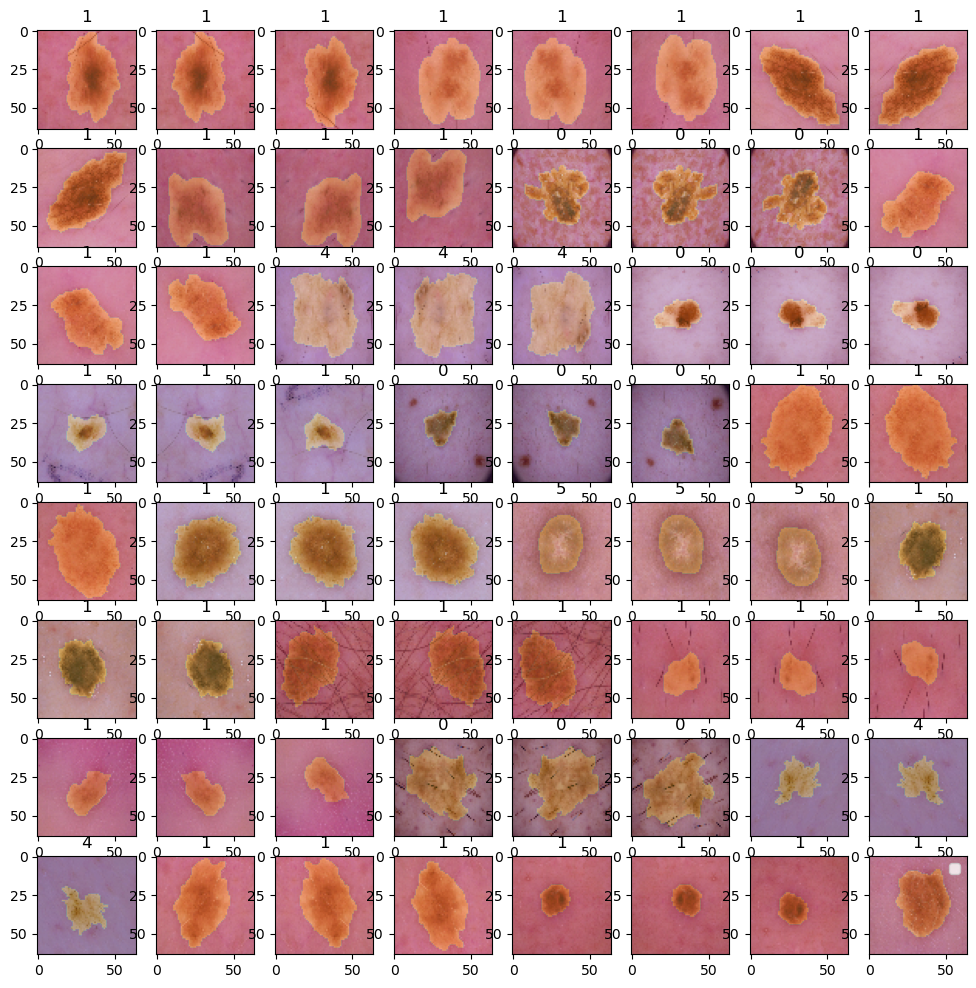

In [13]:
show_sample(images, masks, labels)

In [14]:
indexs = np.random.choice(range(masks.shape[0]), size = (masks.shape[0]), replace = False)
images = images[indexs]
masks = masks[indexs]
labels = labels[indexs]

In [15]:
indexs

array([26001, 30044, 11054, ..., 29968, 12200, 14587])

In [16]:
validSize = 3500
testSize = 1000
validImages = images[:validSize]
validMasks = masks[:validSize]
validLabels = labels[:validSize]
testImages = images[validSize: validSize + testSize]
testMasks = masks[validSize: validSize + testSize]
testLabels = labels[validSize:validSize + testSize]
trainImages = images[validSize + testSize:]
trainMasks = masks[validSize + testSize:]
trainLabels = labels[validSize + testSize:]

In [17]:
trainImages.shape, validImages.shape, trainMasks.shape, validMasks.shape, testImages.shape, testLabels.shape, testMasks.shape

((25545, 64, 64, 3),
 (3500, 64, 64, 3),
 (25545, 64, 64, 1),
 (3500, 64, 64, 1),
 (1000, 64, 64, 3),
 (1000, 7),
 (1000, 64, 64, 1))

In [18]:
np.min(trainImages), np.max(trainImages), np.min(validImages), np.max(validImages)

(0.0, 1.0, 0.0, 1.0)

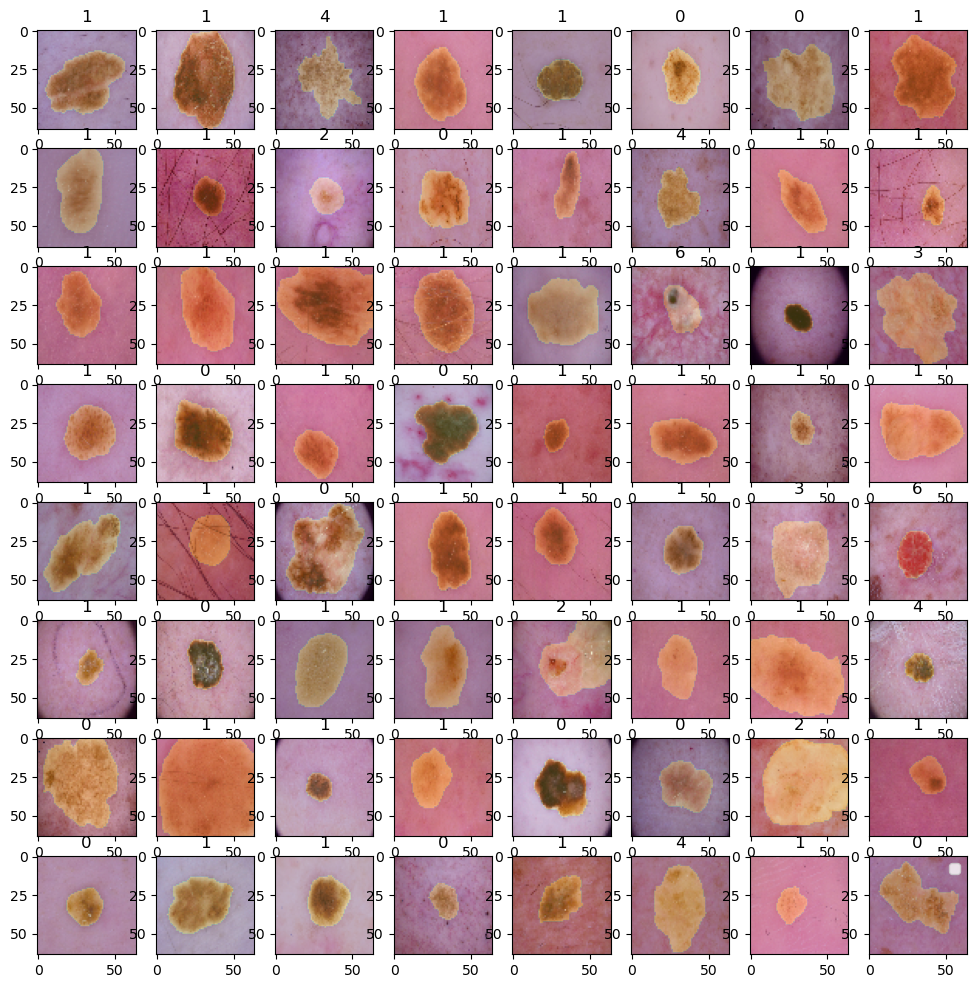

In [19]:
show_sample(validImages, validMasks, validLabels)

# The proposed neural network architecture

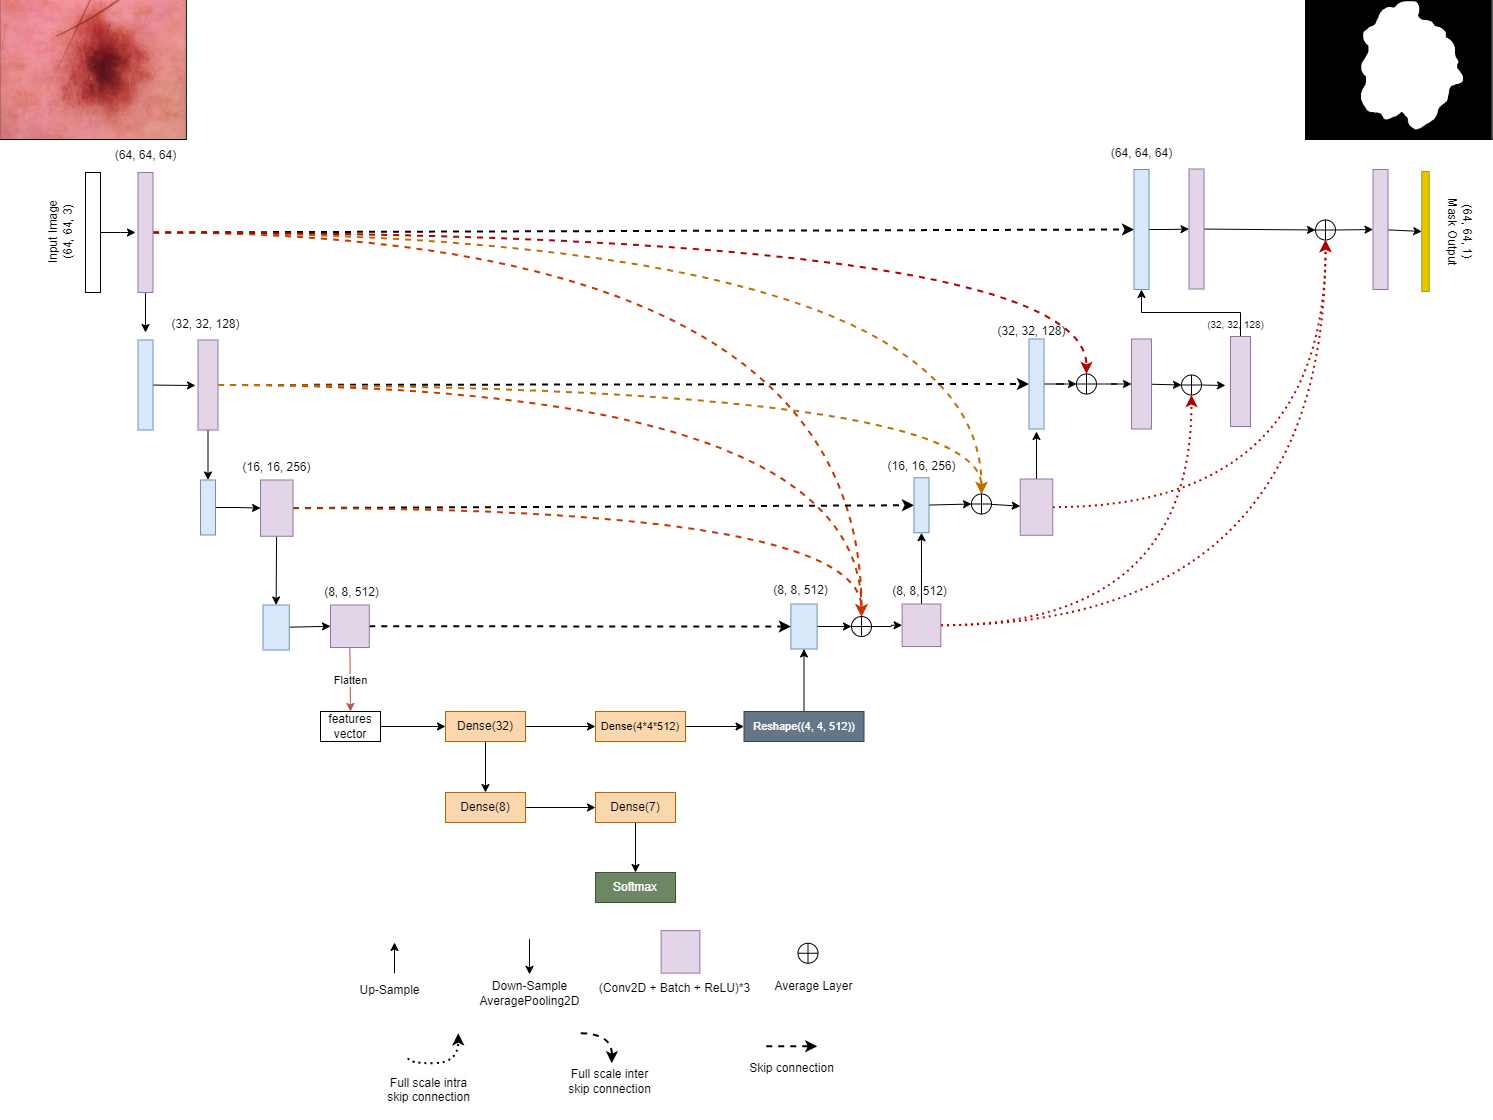

In [20]:
def convolution(input, filter, strides, padding, kernel_size, activation, layernorm):
    x = input
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001),
                     bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001),
                     bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001),
                     bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

In [21]:
def encoder(input, filter, strides, padding, kernel_size, activation, layernorm):
    x = input
    x = convolution(x, filter, strides, padding, kernel_size, activation, layernorm)
    downsample = layers.AveragePooling2D()(x)
    return x, downsample

In [22]:
def decoder(input, skip, otherSkips, filter, strides, padding, kernel_size, activation, layernorm):
    x = input
    x = layers.Conv2DTranspose(filter, kernel_size = kernel_size, padding = padding,
                              strides = 2, )(x)
    x = layers.Activation(activation)(x)
    if otherSkips != None:
        z = None
        s = 2
        list_skips = []
        for skip_ in otherSkips:
            z = layers.BatchNormalization()(layers.Conv2D(filter, kernel_size = 1,strides = s, padding = 'same',
                                                          activation = activation,
                                                          kernel_regularizer = tf.keras.regularizers.L2(0.001),
                                                          bias_regularizer = tf.keras.regularizers.L2(0.001))(skip_))
            list_skips.append(z)
            s = s*2
    if otherSkips != None:
     y = layers.average(list_skips)
    x = layers.average([x, skip])
    if otherSkips != None:
     x = layers.average([x, y])
    x = convolution(x, filter, strides, padding, kernel_size, activation, layernorm)
    return x

In [23]:
input = layers.Input(shape = (64, 64, 3))
filter = 64
kernel = 3
skip1, downsample1 = encoder(input, filter, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
skip2, downsample2 = encoder(downsample1, filter*2, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
skip3, downsample3 = encoder(downsample2, filter*4, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
skip4, downsample4 = encoder(downsample3, filter*8, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
features_map = layers.Flatten()(downsample4)
x = layers.Dropout(0.7)(features_map)
x = layers.Dense(32, name = 'latent_space', kernel_regularizer = tf.keras.regularizers.L2(0.001),
                 bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
xlabels = layers.Dropout(0.6)(x)
xlabels = layers.Dense(8, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001),
                       bias_regularizer = tf.keras.regularizers.L2(0.001))(xlabels)
xlabels = layers.Dropout(0.4)(xlabels)
xlabels = layers.Dense(7,activation = 'softmax', name = 'label')(xlabels)
x = layers.Dense(4*4*512, kernel_regularizer = tf.keras.regularizers.L2(0.001),
                 bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
x = layers.Reshape((4, 4, 512))(x)
upsample2 = decoder(x, skip4, [skip3, skip2, skip1], filter*8, 1,'same', kernel, 'relu', True)
upsample3 = decoder(upsample2, skip3, [skip2, skip1], filter*4, 1,'same', kernel, 'relu', True)
upsample4 = decoder(upsample3, skip2, None, filter*2, 1,'same', kernel, 'relu', True)
upsample4 = layers.average([
    upsample4,
    layers.BatchNormalization()(layers.Conv2DTranspose(filter*2, kernel_size = 1, padding = 'same', strides = 4,
                                                       activation = 'relu')(upsample2)),
])
upsample4 = convolution(upsample4, filter*2, 1, 'same', kernel, 'relu', True)
upsample5 = decoder(upsample4, skip1, None, filter, 1,'same',kernel, 'relu', True)
upsample5 = layers.average([
    upsample5,
    layers.BatchNormalization()(layers.Conv2DTranspose(filter, kernel_size = 1, padding = 'same', strides = 4,
                                                       activation = 'relu')(upsample3)),
    layers.BatchNormalization()(layers.Conv2DTranspose(filter, kernel_size = 1, padding = 'same', strides = 8,
                                                       activation = 'relu')(upsample2)),
])
upsample5 = convolution(upsample5, filter, 1, 'same', kernel, 'relu', True)
output = layers.Conv2D(1, kernel_size = kernel, padding = 'same', strides = 1,)(upsample5)
output = layers.Activation('sigmoid', name = 'mask')(output)
generator = models.Model(inputs = input, outputs = [output, xlabels])
generator.compile(loss = [tf.keras.losses.BinaryFocalCrossentropy(), 'categorical_crossentropy'],
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001,),
                  metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'),
                             tf.keras.metrics.Recall(name = 'recall'), ])
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['batch_normalization[0][0]']

In [24]:
history = generator.fit(trainImages, [trainMasks, trainLabels], epochs = 120, batch_size = 16,
                        validation_data = (validImages, [validMasks, validLabels]), callbacks = [
                            tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_mask_loss',
                                                             mode = 'min',
                                                             restore_best_weights = True),
                        ])

Epoch 1/120
1597/1597 [==============================] - 164s 79ms/step - loss: 7.6702 - mask_loss: 0.0624 - label_loss: 1.6652 - mask_accuracy: 0.9085 - mask_precision: 0.8531 - mask_recall: 0.7957 - label_accuracy: 0.8791 - label_precision: 0.6891 - label_recall: 0.2797 - val_loss: 6.0772 - val_mask_loss: 0.0455 - val_label_loss: 0.9940 - val_mask_accuracy: 0.9342 - val_mask_precision: 0.9301 - val_mask_recall: 0.8184 - val_label_accuracy: 0.9129 - val_label_precision: 0.9032 - val_label_recall: 0.4374
Epoch 2/120
1597/1597 [==============================] - 123s 77ms/step - loss: 5.9582 - mask_loss: 0.0414 - label_loss: 1.4175 - mask_accuracy: 0.9391 - mask_precision: 0.9051 - mask_recall: 0.8633 - label_accuracy: 0.8928 - label_precision: 0.7896 - label_recall: 0.3401 - val_loss: 5.0188 - val_mask_loss: 0.0370 - val_label_loss: 0.9094 - val_mask_accuracy: 0.9458 - val_mask_precision: 0.9349 - val_mask_recall: 0.8595 - val_label_accuracy: 0.9205 - val_label_precision: 0.8756 - val_l

# Performance Evaluation Measures:

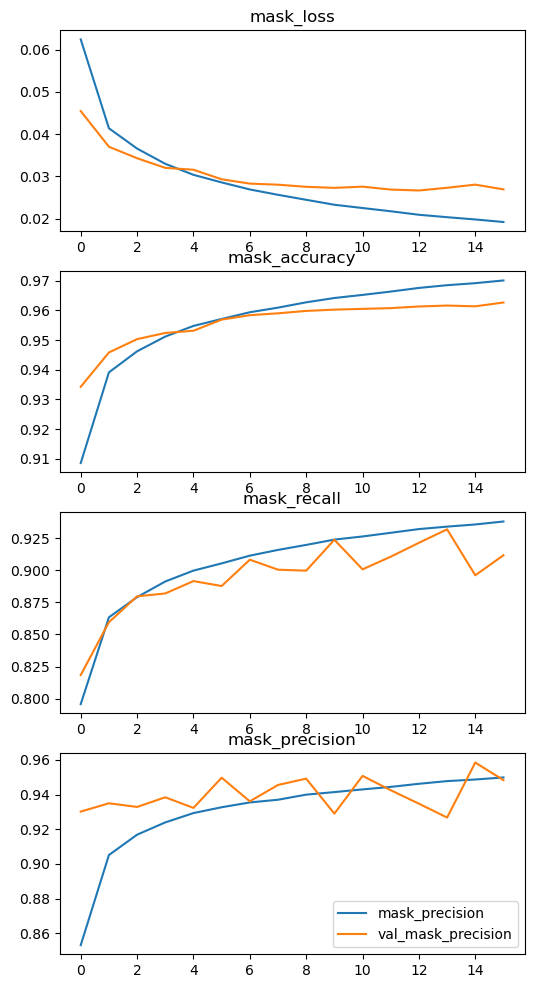

In [25]:
metrics = ['mask_loss','mask_accuracy', 'mask_recall', 'mask_precision']
plt.figure(figsize = (6, 12))
for i in range(4):
    plt.subplot(4, 1, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [26]:
generator.save('/kaggle/working/generator.h5')

**Evaluate the performance of the model on the training data**

In [50]:
generator.evaluate(trainImages, [trainMasks, trainLabels])

799/799 [==============================] - 34s 43ms/step - loss: 3.0212 - mask_loss: 0.0191 - label_loss: 0.6804 - mask_accuracy: 0.9707 - mask_precision: 0.9450 - mask_recall: 0.9456 - label_accuracy: 0.9388 - label_precision: 0.9206 - label_recall: 0.6256


[3.0212302207946777,
 0.01905159279704094,
 0.6803731918334961,
 0.9706714749336243,
 0.9450303316116333,
 0.9456304311752319,
 0.938808262348175,
 0.9206175208091736,
 0.6256018877029419]

**Evaluate model performance on validation data**

In [27]:
generator.evaluate(validImages, [validMasks, validLabels])

110/110 [==============================] - 5s 43ms/step - loss: 3.0527 - mask_loss: 0.0267 - label_loss: 0.7042 - mask_accuracy: 0.9613 - mask_precision: 0.9347 - mask_recall: 0.9214 - label_accuracy: 0.9366 - label_precision: 0.9078 - label_recall: 0.6191


[3.05271577835083,
 0.02668696828186512,
 0.7042231559753418,
 0.9613025188446045,
 0.9347031116485596,
 0.9213773608207703,
 0.9366122484207153,
 0.9078341126441956,
 0.6191428303718567]

**Evaluate model performance on test data**

In [28]:
generator.evaluate(testImages, [testMasks, testLabels])

32/32 [==============================] - 2s 52ms/step - loss: 3.0557 - mask_loss: 0.0287 - label_loss: 0.7052 - mask_accuracy: 0.9587 - mask_precision: 0.9260 - mask_recall: 0.9223 - label_accuracy: 0.9357 - label_precision: 0.8986 - label_recall: 0.6200


[3.0556516647338867,
 0.028663430362939835,
 0.7051825523376465,
 0.9586840867996216,
 0.9259703159332275,
 0.9222707152366638,
 0.9357143044471741,
 0.8985507488250732,
 0.6200000047683716]

In [29]:
class metrics:
  def __init__(self, images, masks):
    self.images = images
    self.masks = masks
  def predict(self,):
    masks_pred, _ = generator.predict(self.images)
    masks_pred = (masks_pred >= 0.5).astype('int')
    return masks_pred
  def flatten(self, pred):
    pred = layers.Flatten()(pred)
    pred  = np.reshape(pred, -1)
    actual = layers.Flatten()(self.masks)
    actual  = np.reshape(actual, -1)
    return actual, pred
  def classification_report(self, actual, pred):
    print(classification_report(actual, pred))
  def othersMetrics(self, actual, pred):
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    m = pd.DataFrame([
    accuracy_score(actual, pred)*100,
    precision_score(actual, pred)*100,
    recall_score(actual, pred)*100,
    ((2*tp)/(2*tp + fp + fn))*100
    ], index = ['accuracy score', 'precision score', 'recall score', 'dice score'],
      columns = ['Metrics For Validation Data'])
    return m

**Evaluate model performance on test data**

In [30]:
metTest = metrics(testImages, testMasks)
pred = metTest.predict()
actual, pred = metTest.flatten(pred)
metTest.classification_report(actual, pred)

32/32 [==============================] - 2s 36ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   2978699
           1       0.93      0.92      0.92   1117301

    accuracy                           0.96   4096000
   macro avg       0.95      0.95      0.95   4096000
weighted avg       0.96      0.96      0.96   4096000



In [31]:
metTest.othersMetrics(actual, pred).head()

Metrics For Validation Data
accuracy score                     95.868408
precision score                    92.597029
recall score                       92.227072
dice score                         92.411680

**Evaluate model performance on validation data**

In [32]:
metValid = metrics(validImages, validMasks)
pred = metValid.predict()
actual, pred = metValid.flatten(pred)
metValid.classification_report(actual, pred)

110/110 [==============================] - 4s 36ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97  10456200
           1       0.93      0.92      0.93   3879800

    accuracy                           0.96  14336000
   macro avg       0.95      0.95      0.95  14336000
weighted avg       0.96      0.96      0.96  14336000



In [33]:
metValid.othersMetrics(actual, pred).head()

Metrics For Validation Data
accuracy score                     96.130253
precision score                    93.470314
recall score                       92.137739
dice score                         92.799243

In [34]:
def segmentation(data, m):
    masks_pred, _ = m.predict(data)
    masks_pred = np.array(masks_pred)
    masks_pred = (masks_pred >= 0.5).astype('int32')
    return masks_pred

In [35]:
def draw(images, masks, y_pred, ran):
  plt.figure(figsize = (12, 50))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(ran):
    plt.subplot(20, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n],)
      plt.title('Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n],)
      plt.imshow(masks[n], alpha = 0.5)
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n],)
      plt.imshow(np.reshape(y_pred[n], (64, 64)), alpha = 0.5)
      plt.title('Predict Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

In [44]:
masks_pred = segmentation(testImages, generator)
masks_pred.shape

32/32 [==============================] - 1s 36ms/step


(1000, 64, 64, 1)

# Visual samples of automatically locating skin lesion.

**A visual demonstration of the model's ability to predict the location of a skin lesion and determine its extent, on test Data**

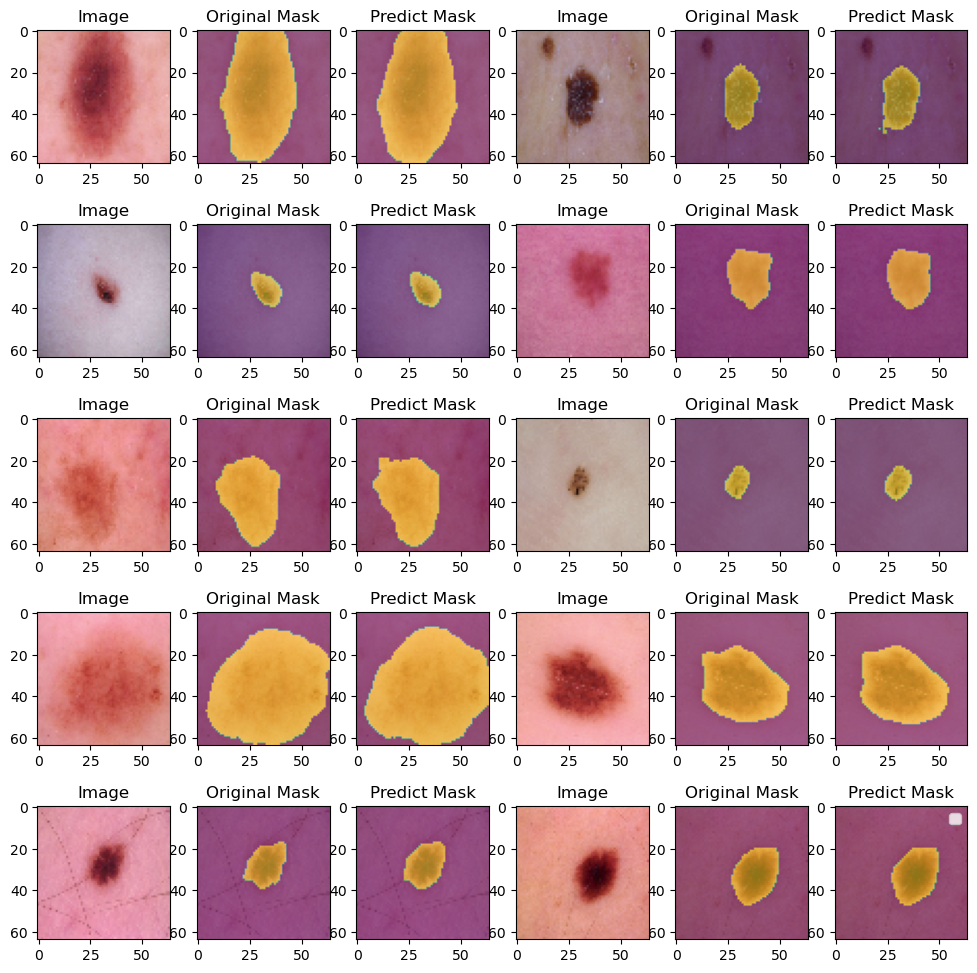

In [46]:
draw(testImages, testMasks, masks_pred, 30)

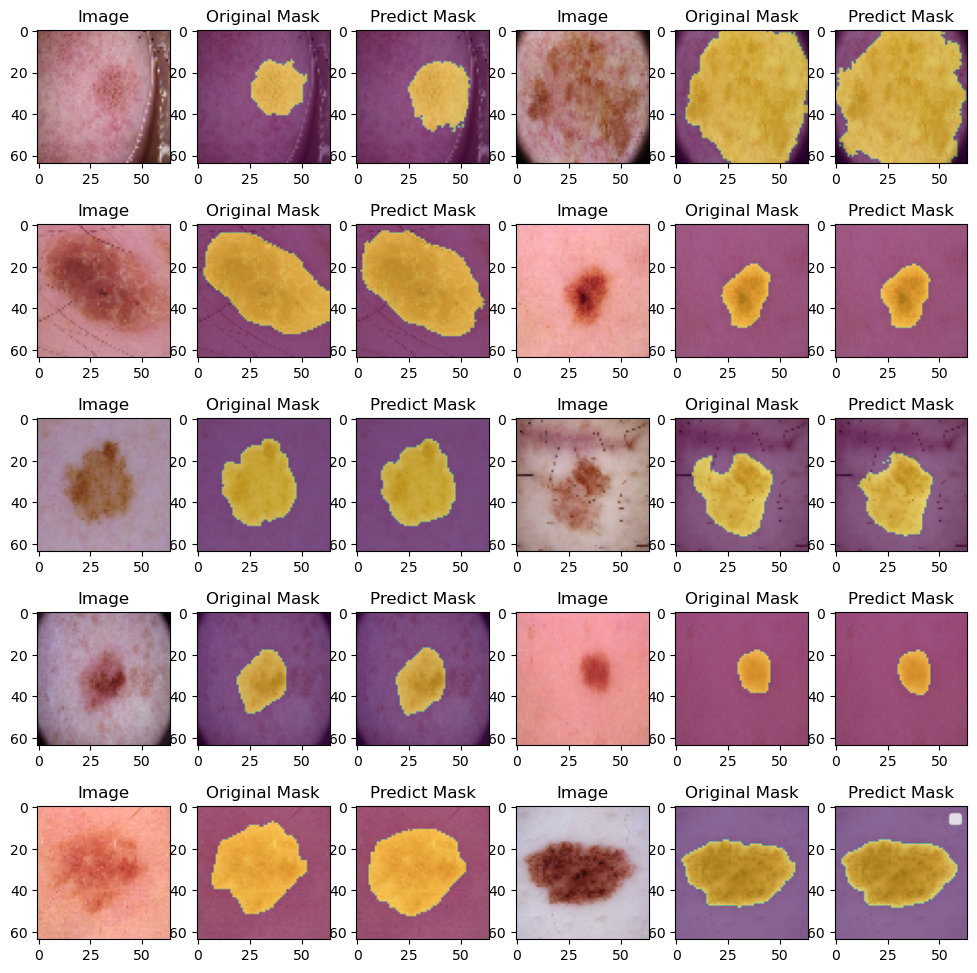

In [48]:
draw(testImages, testMasks, masks_pred, 30)

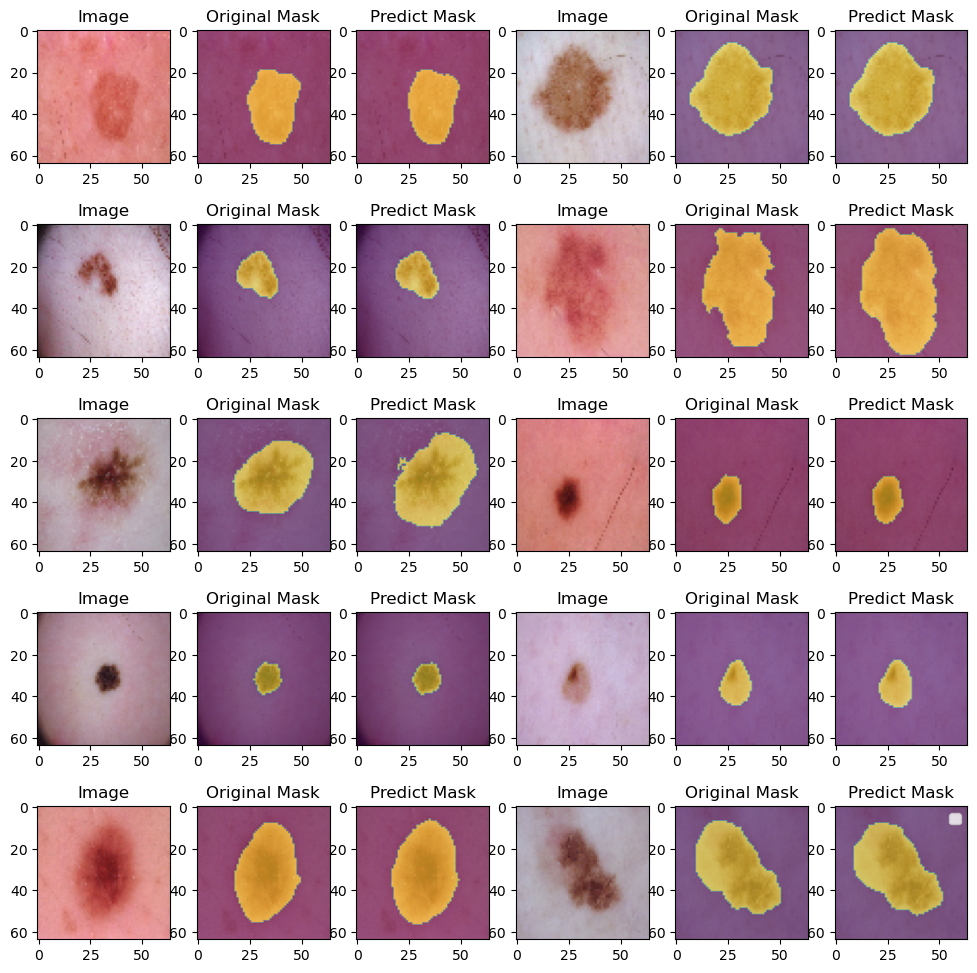

In [49]:
draw(testImages, testMasks, masks_pred, 30)

**A visual demonstration of the model's ability to predict the location of a skin lesion and determine its extent, on validation Data**

In [40]:
masks_pred = segmentation(validImages, generator)
masks_pred.shape

110/110 [==============================] - 4s 36ms/step


(3500, 64, 64, 1)

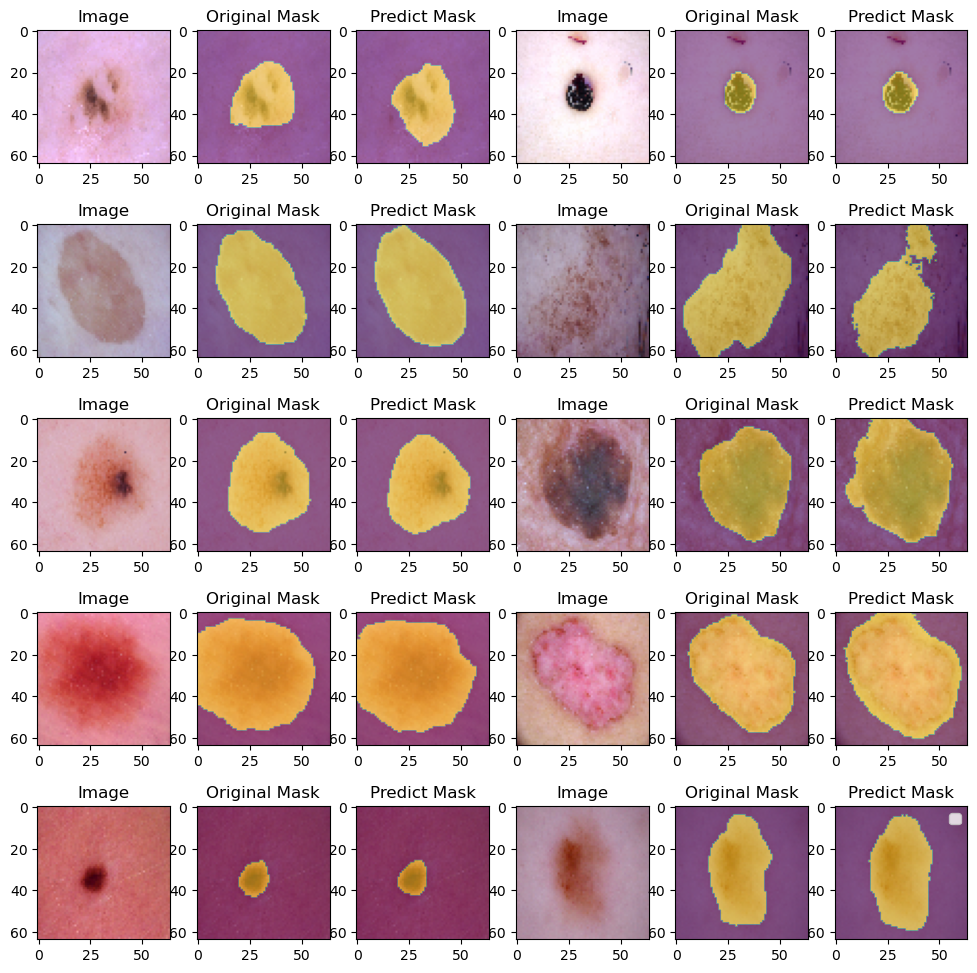

In [41]:
draw(validImages, validMasks, masks_pred, 30)

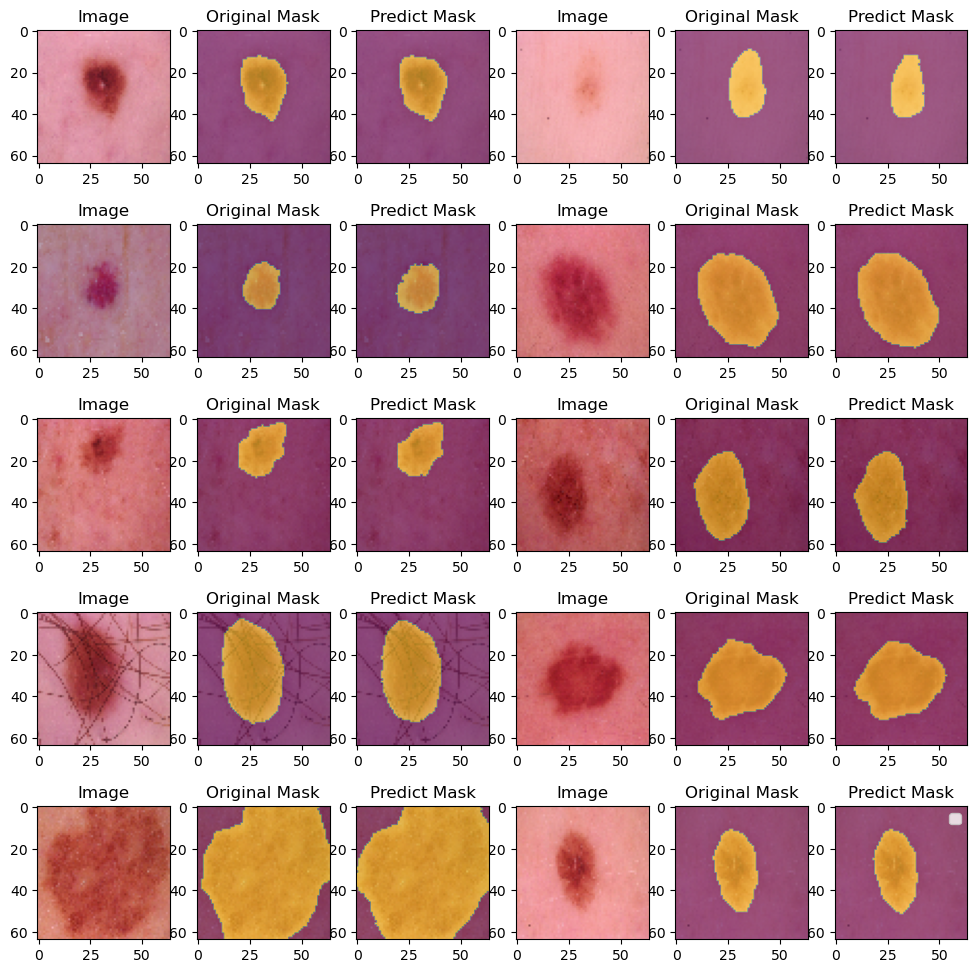

In [42]:
draw(validImages, validMasks, masks_pred, 30)